In [1]:
import nltk
import pandas as pd
import numpy as np
import re
import time
import sys
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from pprint import pprint
from functools import reduce
from matplotlib import pyplot as plt
import string

In [2]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import KFold
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
from tqdm import tqdm
from tabulate import tabulate

In [3]:
anxiety_2018 = pd.read_csv("anxiety_2018.csv",encoding='utf-8')
anxiety_2019 = pd.read_csv("anxiety_2019.csv",encoding='utf-8')
anxiety_2018 = anxiety_2018[['subreddit','post']]
anxiety_2019 = anxiety_2019[['subreddit','post']]
anxiety = np.concatenate((anxiety_2018,anxiety_2019))
anxiety = anxiety[1:100]

bpd_2018 = pd.read_csv("bpd_2018.csv",encoding='utf-8')
bpd_2019 = pd.read_csv("bpd_2019.csv",encoding='utf-8')
bpd_2018 = bpd_2018[['subreddit','post']]
bpd_2019 = bpd_2019[['subreddit','post']]
bpd = np.concatenate((bpd_2018,bpd_2019))
bpd = bpd[1:100]

ptsd_2018 = pd.read_csv("ptsd_2018.csv",encoding='utf-8')
ptsd_2019 = pd.read_csv("ptsd_2019.csv",encoding='utf-8')
ptsd_2018 = ptsd_2018[['subreddit','post']]
ptsd_2019 = ptsd_2019[['subreddit','post']]
ptsd = np.concatenate((ptsd_2018,ptsd_2019))
ptsd = ptsd[1:100]


In [4]:
array = np.concatenate((anxiety,bpd,ptsd))
df = pd.DataFrame(array, columns = ['subreddit','post'])


In [5]:
df.shape

(297, 2)

In [6]:
scale_mapper = {'anxiety' :0,
 'bpd':1,
 'ptsd':2}
df['subreddit'] = df['subreddit'].replace(scale_mapper)
df

,subreddit,post
0,0,Meditation is making me anxious I do a couple ...
1,0,Rant about anxiety meds - I've been self medic...
2,0,Some advice for my friend please? I dated this...
3,0,Feeling like I’m back to where I started. I’ve...
4,0,Never had physical symptoms until medication H...
...,...,...
292,2,I feel like it's my fault It's making me want ...
293,2,PTSD triggered by people in general Is there s...
294,2,"It is offensive to use the term ""PTSD"" lightly..."
295,2,Has anyone else thrown up from anxiety/panic? ...


In [7]:
# df['post'].value_counts().plot.bar(color = 'pink', figsize = (6, 4))

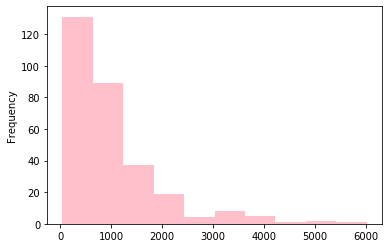

In [8]:
# checking the distribution of tweets in the data

length_post = df['post'].str.len().plot.hist(color = 'pink', figsize = (6, 4))


In [9]:
# df.groupby('').mean()['subreddit'].plot.hist(color = 'black', figsize = (6, 4),)
# plt.title('variation of length')
# plt.xlabel('Length')
# plt.show()

Text(0.5, 1.0, 'Most Frequently Occuring Words - Top 30')

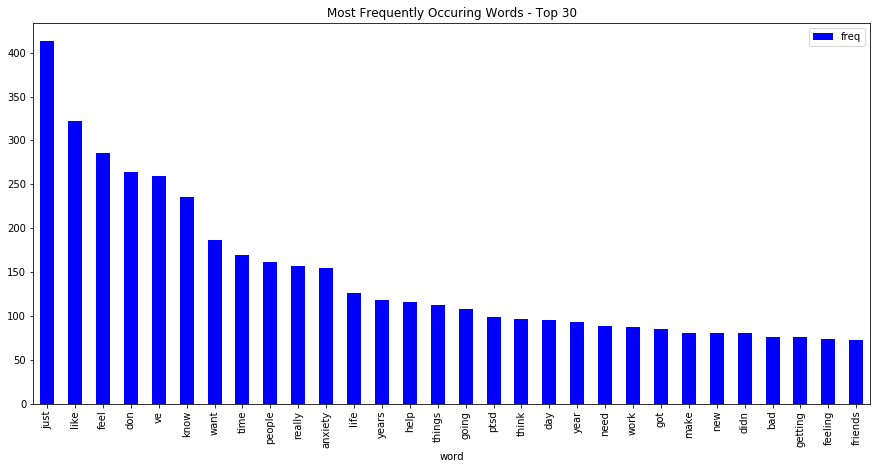

In [10]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(stop_words = 'english')
words = cv.fit_transform(df.post)

sum_words = words.sum(axis=0)

words_freq = [(word, sum_words[0, i]) for word, i in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)

frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])

frequency.head(30).plot(x='word', y='freq', kind='bar', figsize=(15, 7), color = 'blue')
plt.title("Most Frequently Occuring Words - Top 30")

Text(0.5, 1.0, 'WordCloud - Vocabulary from Reviews')

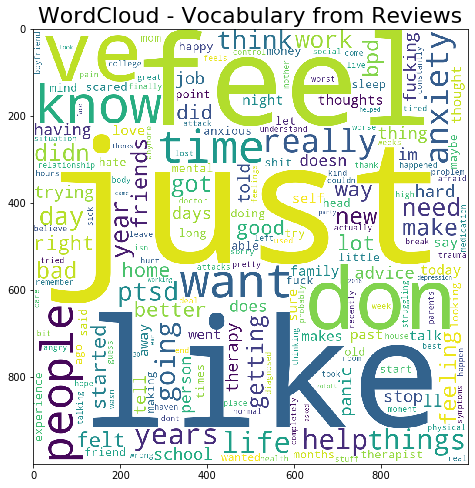

In [11]:
from wordcloud import WordCloud

wordcloud = WordCloud(background_color = 'white', width = 1000, height = 1000).generate_from_frequencies(dict(words_freq))

plt.figure(figsize=(10,8))
plt.imshow(wordcloud)
plt.title("WordCloud - Vocabulary from Reviews", fontsize = 22)

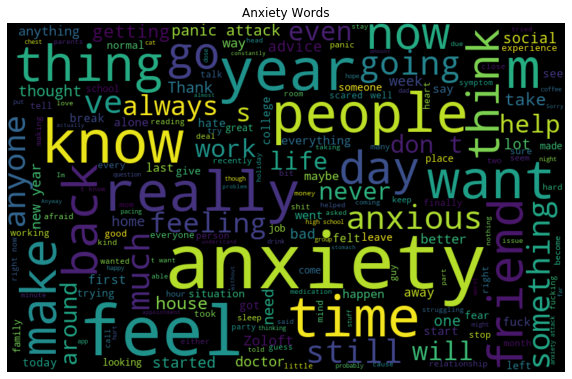

In [12]:
anxiety_words =' '.join([text for text in df['post'][df['subreddit'] == 0]])

wordcloud = WordCloud(width=800, height=500, random_state = 0, max_font_size = 110).generate(anxiety_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Anxiety Words')
plt.show()

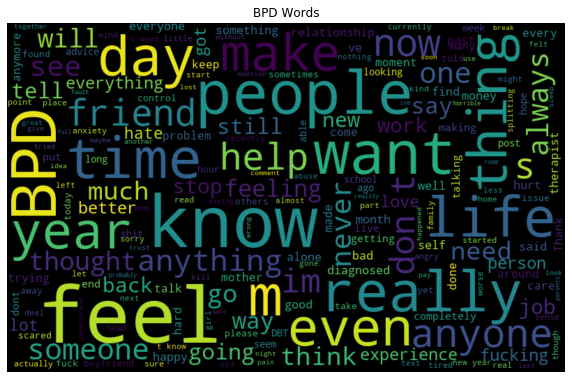

In [13]:
bpd_words =' '.join([text for text in df['post'][df['subreddit'] == 1]])

wordcloud = WordCloud(width=800, height=500, random_state = 0, max_font_size = 110).generate(bpd_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('BPD Words')
plt.show()

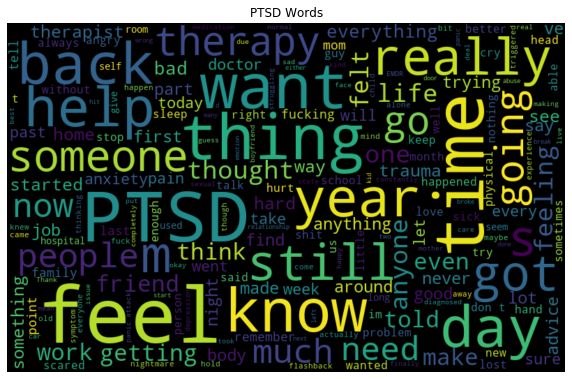

In [14]:
ptsd_words =' '.join([text for text in df['post'][df['subreddit'] == 2]])

wordcloud = WordCloud(width=800, height=500, random_state = 0, max_font_size = 110).generate(ptsd_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('PTSD Words')
plt.show()

In [15]:
# tokenizing the words present in the training set

tokenized_tweet = df['post'].apply(lambda x: x.split()) 

# importing gensim
import gensim

# creating a word to vector model
model_w2v = gensim.models.Word2Vec(
            tokenized_tweet,
            vector_size=200, # desired no. of features/independent variables 
            window=5, # context window size
            min_count=2,
            sg = 1, # 1 for skip-gram model
            hs = 0,
            negative = 10, # for negative sampling
            workers= 2, # no.of cores
            seed = 34)

model_w2v.train(tokenized_tweet, total_examples= len(df['post']), epochs=20)

(755305, 1136740)

In [16]:
# Cosine similarity
model_w2v.wv.most_similar(positive = "depression")

[('(a', 0.8277893662452698),
 ('pleased', 0.8200645446777344),
 ('severely', 0.7789026498794556),
 ('phobia', 0.753248929977417),
 ('anxiety?', 0.7468628883361816),
 (':', 0.744753897190094),
 ('symptom', 0.7390735745429993),
 ('separation', 0.7389795184135437),
 ('surrounding', 0.7372210621833801),
 ('C-PTSD', 0.7352338433265686)]

In [17]:
model_w2v.wv.most_similar(negative = "anxiety")

[('find', 0.058723557740449905),
 ('try', 0.01788518764078617),
 ('mind', -0.020208464935421944),
 ('being', -0.027214575558900833),
 ('less', -0.029135800898075104),
 ('something', -0.0291928481310606),
 ('is', -0.03767998144030571),
 ('usually', -0.048114318400621414),
 ('bring', -0.060937728732824326),
 ("I'm", -0.06131832301616669)]

In [18]:
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models.doc2vec import TaggedDocument

D:\Anaconda\lib\site-packages\tqdm\std.py:648: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [19]:
def add_label(twt):
    output = []
    for i, s in zip(twt.index, twt):
        output.append(TaggedDocument(s, ["tweet_" + str(i)]))
    return output

# label all the tweets
labeled_tweets = add_label(tokenized_tweet)

labeled_tweets[:6]

[TaggedDocument(words=['Meditation', 'is', 'making', 'me', 'anxious', 'I', 'do', 'a', 'couple', 'sessions', 'a', 'day', 'on', 'headspace.', 'Just', 'opening', 'the', 'app', 'gets', 'my', 'heart', 'racing.', 'The', 'silence,', 'I', 'can’t', 'run', 'from', 'my', 'worries', 'or', 'drown', 'them', 'out.', 'It’s', 'torture.', 'Just', 'me', 'and', 'my', 'mind.', 'How', 'long', 'until', 'it', 'gets', 'easier?', 'I’m', 'about', 'two', 'days', 'in', 'right', 'now', 'and', 'it’s', 'my', 'most', 'dreaded', 'part', 'of', 'the', 'day.'], tags=['tweet_0']),
 TaggedDocument(words=['Rant', 'about', 'anxiety', 'meds', '-', "I've", 'been', 'self', 'medicating', 'with', 'Benzodiazepines', '(Valium)', 'First', 'it', 'started', 'with', 'cannabis,', 'a', 'very', 'no', 'nonsense', 'substance', 'at', 'face', 'value', 'but', 'ultimately', 'terrible', 'as', 'an', 'anxiety', 'medication', '(currently).', 'You', 'simply', "can't", 'dose', 'this', 'stuff', 'appropriately,', 'too', 'much', 'causes', 'the', 'exact',

In [20]:
# removing unwanted patterns from the data

import re
import nltk

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

In [21]:
corpus = []

for i in range(len(df['post'])):
    review = re.sub('[^a-zA-Z]', ' ', df['post'][i])
    review = review.lower()
    review = review.split()
    
    ps = PorterStemmer()
    
    # stemming
    review = [ps.stem(word) for word in review if not word in set(stopwords.words('english'))]
    
    # joining them back with space
    review = ' '.join(review)
    corpus.append(review)
corpus

['medit make anxiou coupl session day headspac open app get heart race silenc run worri drown tortur mind long get easier two day right dread part day',
 'rant anxieti med self medic benzodiazepin valium first start cannabi nonsens substanc face valu ultim terribl anxieti medic current simpli dose stuff appropri much caus exact symptom tri treat toler buildup queue valium decid self medic tri week twice week three time week fuck time take break take time research someth right benzodiazepin need know nah mess cope skill take amount time look benzo withdraw list sure leav sour tast shit joke withdraw deadli alcohol system drug work bodi last thing someon anxieti mess way take thing therapeut short term condit short term incred import fragil system need respect gaba soon throw whack immedi doubl tripl amount anxieti could experienc unless keep pill eventu need make question benzo worth think fuck nah thing abhorr opiat mind sorri anyon forc onto big dosag battl anxieti believ lead astray 

In [22]:
#Bag of Words

from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(max_features = 2500)
x = cv.fit_transform(corpus).toarray()
y = df.iloc[:, 0]

print(x.shape)
print(y.shape)

print(y)

(297, 2500)
(297,)
0      0
1      0
2      0
3      0
4      0
      ..
292    2
293    2
294    2
295    2
296    2
Name: subreddit, Length: 297, dtype: int64


In [23]:
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size = 0.20, random_state = 42)

print(x_train.shape)
print(x_valid.shape)
print(y_train.shape)
print(y_valid.shape)

(237, 2500)
(60, 2500)
(237,)
(60,)


In [24]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

x_train = sc.fit_transform(x_train)
x_valid = sc.transform(x_valid)
#x_test = sc.transform(x_test)

y_valid

167    1
211    2
63     0
154    1
5      0
77     0
183    1
158    1
9      0
139    1
285    2
78     0
92     0
101    1
42     0
222    2
283    2
33     0
263    2
148    1
245    2
45     0
60     0
46     0
278    2
237    2
175    1
234    2
17     0
279    2
111    1
219    2
24     0
82     0
7      0
75     0
108    1
84     0
90     0
73     0
116    1
126    1
233    2
59     0
195    1
208    2
97     0
185    1
176    1
124    1
93     0
294    2
182    1
275    2
192    1
292    2
25     0
224    2
6      0
181    1
Name: subreddit, dtype: int64

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

model = RandomForestClassifier()
model.fit(x_train, y_train)

y_pred = model.predict(x_valid)

print("Training Accuracy :", model.score(x_train, y_train))
print("Validation Accuracy :", model.score(x_valid, y_valid))

# # calculating the f1 score for the validation set
# print("F1 score :", f1_score(y_valid, y_pred))

# confusion matrix
cm = confusion_matrix(y_valid, y_pred)
print(cm)

D:\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Training Accuracy : 0.9957805907172996
Validation Accuracy : 0.5166666666666667
[[10 10  4]
 [ 3 12  4]
 [ 4  4  9]]


In [26]:
from xgboost import XGBClassifier

model = XGBClassifier()
model.fit(x_train, y_train)

y_pred = model.predict(x_valid)

print("Training Accuracy :", model.score(x_train, y_train))
print("Validation Accuracy :", model.score(x_valid, y_valid))

# calculating the f1 score for the validation set
# print("f1 score :", f1_score(y_valid, y_pred))

# confusion matrix
cm = confusion_matrix(y_valid, y_pred)
print(cm)

D:\Anaconda\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:19:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training Accuracy : 1.0
Validation Accuracy : 0.65
[[15  4  5]
 [ 3 11  5]
 [ 0  4 13]]
